In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

In [31]:
test = pd.read_csv('train.csv')
y_pred_naivebayes = pd.read_csv('y_pred_tf-idf-NaiveBayes.csv')
y_pred_tfidfsvm = pd.read_csv('y_pred_proba_tf-idfsvm.csv')
y_pred_tfidfsvm=y_pred_tfidfsvm["0"]
y_pred_naivebayes=y_pred_naivebayes["0"]
y_pred_embedding = pd.read_csv('y_pred_embeddings.csv')
y_pred_embedding=y_pred_embedding.values

In [32]:
y_pred_naivebayes

0       1
1       2
2       2
3       2
4       2
       ..
1198    2
1199    2
1200    2
1201    2
1202    2
Name: 0, Length: 1203, dtype: int64

In [33]:
y_pred_tfidfsvm

0       1
1       2
2       2
3       2
4       2
       ..
1198    2
1199    2
1200    2
1201    2
1202    2
Name: 0, Length: 1203, dtype: int64

In [34]:
y_pred_embedding

array([[   0,    2],
       [   1,    2],
       [   2,    2],
       ...,
       [1200,    2],
       [1201,    2],
       [1202,    2]], dtype=int64)

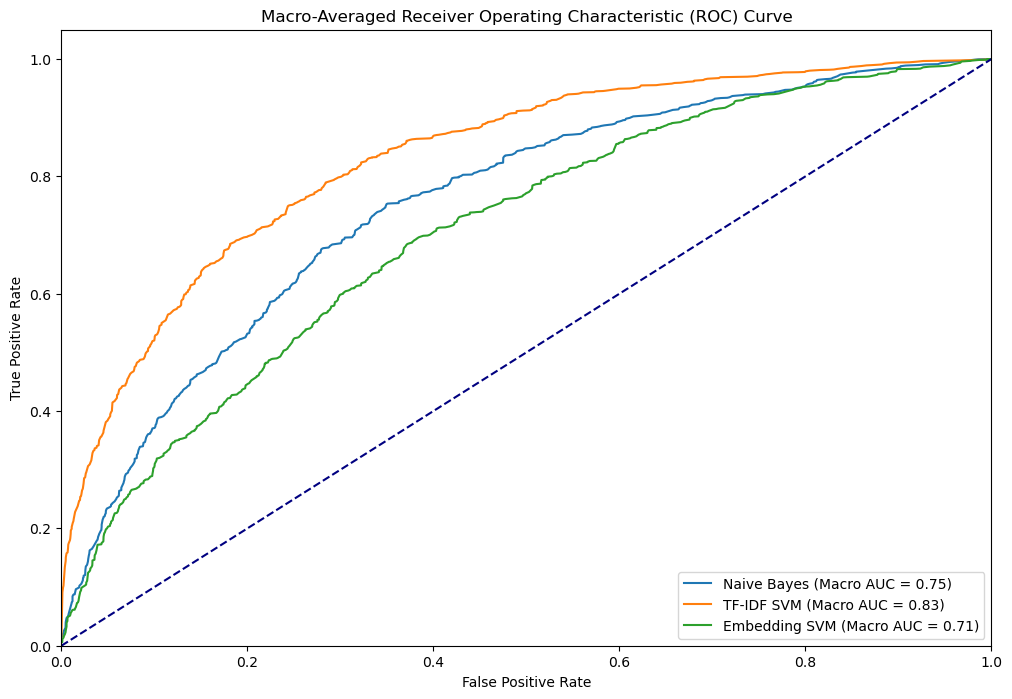

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Function to clean text 
def apply_cleaning(texts):
    return texts  

# Function to convert text to vectors using Word2Vec
def review_to_vector(review, model):
    words = review.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Load and preprocess data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train["text"] = apply_cleaning(train["text"])
test["text"] = apply_cleaning(test["text"])

X_train = train["text"]
X_test = test["text"]
y_train = train["sentiment"]
y_test = test["sentiment"]

classes = np.unique(y_train)
n_classes = len(classes)

# Train Word2Vec model on the training text
w2v_model = Word2Vec([text.split() for text in X_train], vector_size=300, window=7, min_count=5)

# Convert text to vectors
X_train_vectors = np.array([review_to_vector(review, w2v_model) for review in X_train])
X_test_vectors = np.array([review_to_vector(review, w2v_model) for review in X_test])

tfidf = TfidfVectorizer()
naive_bayes_model = make_pipeline(tfidf, MultinomialNB())
naive_bayes_model.fit(X_train, y_train)
y_pred_probs_naivebayes = naive_bayes_model.predict_proba(X_test)

# SVM with TF-IDF
tfidf_svm_model = make_pipeline(tfidf, LinearSVC(C=1, penalty='l2', loss="squared_hinge", dual=False))
tfidf_svm_model = CalibratedClassifierCV(tfidf_svm_model, method='sigmoid')  # Calibrate to get probabilities
tfidf_svm_model.fit(X_train, y_train)
y_pred_probs_tfidfsvm = tfidf_svm_model.predict_proba(X_test)

# SVM with Word2Vec embeddings
embedding_svm_model = LinearSVC(C=1, penalty='l2', loss="squared_hinge", dual=False)
embedding_svm_model = CalibratedClassifierCV(embedding_svm_model, method='sigmoid')  # Calibrate to get probabilities
embedding_svm_model.fit(X_train_vectors, y_train)
y_pred_probs_embedding = embedding_svm_model.predict_proba(X_test_vectors)

# Binarize the true labels
y_true_binarized = label_binarize(y_test, classes=classes)

# Initialize dictionaries to store FPR, TPR, and AUC for each class and each model
fpr_naivebayes, tpr_naivebayes, auc_naivebayes = dict(), dict(), dict()
fpr_tfidfsvm, tpr_tfidfsvm, auc_tfidfsvm = dict(), dict(), dict()
fpr_embedding, tpr_embedding, auc_embedding = dict(), dict(), dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr_naivebayes[i], tpr_naivebayes[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs_naivebayes[:, i])
    fpr_tfidfsvm[i], tpr_tfidfsvm[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs_tfidfsvm[:, i])
    fpr_embedding[i], tpr_embedding[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs_embedding[:, i])
    auc_naivebayes[i] = auc(fpr_naivebayes[i], tpr_naivebayes[i])
    auc_tfidfsvm[i] = auc(fpr_tfidfsvm[i], tpr_tfidfsvm[i])
    auc_embedding[i] = auc(fpr_embedding[i], tpr_embedding[i])

# Compute macro-average ROC curve and ROC area
def compute_macro_roc_auc(fpr, tpr, n_classes):
    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Average it and compute AUC
    mean_tpr /= n_classes
    macro_fpr = all_fpr
    macro_tpr = mean_tpr
    macro_auc = auc(macro_fpr, macro_tpr)
    return macro_fpr, macro_tpr, macro_auc

macro_fpr_naivebayes, macro_tpr_naivebayes, macro_auc_naivebayes = compute_macro_roc_auc(fpr_naivebayes, tpr_naivebayes, n_classes)
macro_fpr_tfidfsvm, macro_tpr_tfidfsvm, macro_auc_tfidfsvm = compute_macro_roc_auc(fpr_tfidfsvm, tpr_tfidfsvm, n_classes)
macro_fpr_embedding, macro_tpr_embedding, macro_auc_embedding = compute_macro_roc_auc(fpr_embedding, tpr_embedding, n_classes)

# Plot the macro-average ROC curves for each model
plt.figure(figsize=(12, 8))
plt.plot(macro_fpr_naivebayes, macro_tpr_naivebayes, label='Naive Bayes (Macro AUC = {:.2f})'.format(macro_auc_naivebayes))
plt.plot(macro_fpr_tfidfsvm, macro_tpr_tfidfsvm, label='TF-IDF SVM (Macro AUC = {:.2f})'.format(macro_auc_tfidfsvm))
plt.plot(macro_fpr_embedding, macro_tpr_embedding, label='Embedding SVM (Macro AUC = {:.2f})'.format(macro_auc_embedding))

# Customize the plot
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Add diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Averaged Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()


In [36]:
y_pred_binary_tfidf = pd.read_csv("y_pred_tf-idfsvm.csv")
y_pred_binary_embedding = pd.read_csv("y_pred_embeddings.csv")
y_pred_binary_naivebayes = pd.read_csv("y_pred_tf-idf-NaiveBayes.csv")

In [37]:
test["y_pred_binary_tfidf"] = y_pred_binary_tfidf["0"]
test["y_pred_binary_embedding"] = y_pred_binary_embedding["0"]
test["y_pred_binary_naivebayes"] = y_pred_binary_naivebayes["0"]

In [47]:
pd.set_option('display.max_colwidth', None)
test[test["sentiment"] != test["y_pred_binary_tfidf"]].sample(5)
test[test["sentiment"] != test["y_pred_binary_embedding"]].sample(5)
test[test["sentiment"] != test["y_pred_binary_naivebayes"]].sample(5)

,text,sentiment,y_pred_binary_tfidf,y_pred_binary_embedding,y_pred_binary_naivebayes
321,"i like the texture of it and the fact that there’s not really a smell to it, does not irritate my skin and leaves it very hydrated in the morning",1,2,2,2
1094,"As a lover of glycolic acid peel pads, I was thrilled when GOOP gifted me their GOOPGLOW 15% Glycolic Acid Overnight Glow Peel!My box arrived kind of beat up, but the pads were unharmed in their easy to open foil envelopes. Each pad is soaked in plenty of product, with a textured exfoliating side and a soft cotton side. They also have a little pocket to slip two fingers in to help with application. You apply this product once a week, at night. It leaves a definite sticky feel to the skin, which disappears by morning. You are also able to apply moisturizer after letting the acid sit on your skin for 15 minutes.The result: Amazingly soft, bright skin! I couldn’t stop looking at it or touching it!",1,2,2,2
575,Works great. Sheer w/just a hint of color,1,2,2,2
311,Ordered this online because of all of the amazing reviews but dear God the smell is repulsive. Wish I could’ve given it a chance but had to wash it off immediately to not throw up,0,2,2,2
770,"There’s nothing in particular that wows me about this moisturizer but I seem to be going back to it after trying out other ones. For me it’s a great summer moisturizer - lightweight and non-greasy. For the price point it’s definitely worth it, however if your skin is on the drier side like mine you will still have to use an overnight mask/ moisturizer as this won’t be enough.",1,1,2,2


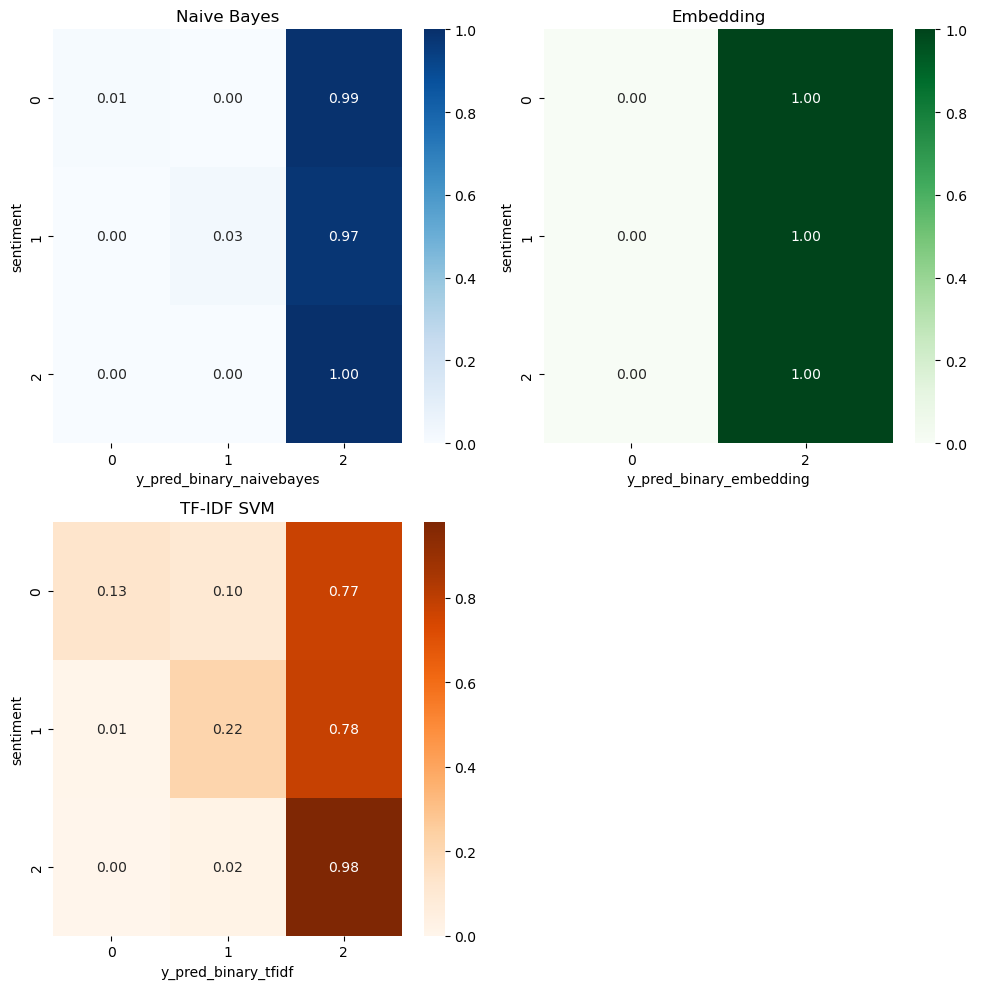

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot the confusion matrices
sns.heatmap(pd.crosstab(test['sentiment'], test['y_pred_binary_tfidf'], normalize='index'), annot=True, fmt='.2f', cmap='Oranges', ax=axes[1, 0]).set_title('TF-IDF SVM')
sns.heatmap(pd.crosstab(test['sentiment'], test['y_pred_binary_embedding'], normalize='index'), annot=True, fmt='.2f', cmap='Greens', ax=axes[0, 1]).set_title('Embedding')
sns.heatmap(pd.crosstab(test['sentiment'], test['y_pred_binary_naivebayes'], normalize='index'), annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 0]).set_title('Naive Bayes')

# Hide the unused subplot
axes[1, 1].axis('off')
plt.tight_layout()
plt.show()